# Survey Models - Self Selected
This notebook models the survey data with hand-selected features using SMOTEN and NearMiss. 

### Import Libraries & Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectPercentile
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTEN
from imblearn.under_sampling import NearMiss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score

In [2]:
# read in data
df = pd.read_csv('./adult19_clean.csv')
df.head()

,HHX,URBRRL,REGION,INTV_QRT,SEX_A,EDUC_A,AFNOW,HISP_A,HISPALLP_A,RACEALLP_A,...,HOSPONGT_A,RX12M_A,SHTFLU12M_A,PAIFRQ3M_A,SMKCIGST_A,LEGMSTAT_A,PARSTAT_A,AFVET_A,CITZNSTP_A,EMPWRKLSWK_A
0,H048109,4,3,1,1,7,2.0,2,3,2,...,2,1,2,2.0,4,3,1,1,1,2
1,H027044,4,3,1,2,6,1.0,2,2,1,...,2,2,2,1.0,2,3,3,2,1,1
2,H058855,4,3,1,1,5,8.0,2,2,1,...,2,1,1,2.0,4,3,3,1,1,2
3,H031993,4,3,1,1,7,2.0,1,1,8,...,2,1,2,2.0,4,3,3,1,1,1
4,H007122,1,3,1,1,5,2.0,2,2,1,...,2,1,1,3.0,1,3,1,2,1,1


In [3]:
# changing datatypes for all columns except the target to objects so they can be dummified since they are categorical values
df = df.astype(object)
df['CHDEV_A'] = df['CHDEV_A'].astype(int)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31891 entries, 0 to 31890
Data columns (total 56 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   HHX           31891 non-null  object
 1   URBRRL        31891 non-null  object
 2   REGION        31891 non-null  object
 3   INTV_QRT      31891 non-null  object
 4   SEX_A         31891 non-null  object
 5   EDUC_A        31891 non-null  object
 6   AFNOW         31891 non-null  object
 7   HISP_A        31891 non-null  object
 8   HISPALLP_A    31891 non-null  object
 9   RACEALLP_A    31891 non-null  object
 10  PCNTTC        31891 non-null  object
 11  PCNT18UPTC    31891 non-null  object
 12  PCNTLT18TC    31891 non-null  object
 13  OVER65FLG_A   31891 non-null  object
 14  MAXEDUC_A     31891 non-null  object
 15  PHSTAT_A      31891 non-null  object
 16  HYPEV_A       31891 non-null  object
 17  CHLEV_A       31891 non-null  object
 18  CHDEV_A       31891 non-null  int64 
 19  ANGE

## Modeling

In [11]:
X = df.drop(columns=['CHDEV_A', 'HHX'])
y = df['CHDEV_A']

In [12]:
X_dum = pd.get_dummies(X, drop_first=True)

In [13]:
X_dum.shape

(31891, 233)

In [14]:
y.value_counts(normalize=True)

0    0.942115
1    0.057885
Name: CHDEV_A, dtype: float64

In [18]:
# splitting data into train and test sets for X and y variables
X_train, X_test, y_train, y_test = train_test_split(X_dum, y, stratify=y, random_state=19)

### SMOTEN

In [74]:
# creating instances to create balanced classes 
sm = SMOTEN(random_state=19)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [75]:
X_train_res.shape, y_train_res.shape

((45068, 233), (45068,))

#### Base Model

In [76]:
y_train_res.value_counts(normalize=True)

1    0.5
0    0.5
Name: CHDEV_A, dtype: float64

In [77]:
y_test.value_counts(normalize=True)

0    0.942054
1    0.057946
Name: CHDEV_A, dtype: float64

#### Logistic Regression

In [78]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_res, y_train_res)

LogisticRegression(max_iter=1000)

In [79]:
lr_preds = lr.predict(X_test)
lr_cm = confusion_matrix(y_test, lr_preds)
ConfusionMatrixDisplay(lr_cm, display_labels=['No', 'Yes']).plot();

In [81]:
print(classification_report(y_test, lr_preds))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      7511
           1       0.67      0.41      0.51       462

    accuracy                           0.95      7973
   macro avg       0.82      0.70      0.74      7973
weighted avg       0.95      0.95      0.95      7973



In [82]:
lr.score(X_train_res, y_train_res), lr.score(X_test, y_test)

(0.975548060708263, 0.9542204941678164)

In [83]:
roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])

0.904460470962934

#### Decision Tree

In [84]:
tree = DecisionTreeClassifier(random_state=19)
tree.fit(X_train_res, y_train_res)

DecisionTreeClassifier(random_state=19)

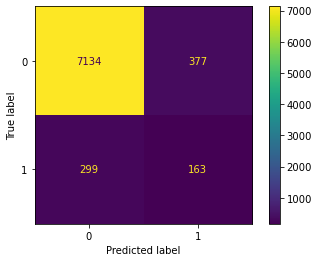

In [85]:
tree_preds = tree.predict(X_test)
tree_cm = confusion_matrix(y_test, tree_preds)
ConfusionMatrixDisplay(tree_cm).plot();

In [86]:
print(classification_report(y_test, tree_preds))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      7511
           1       0.30      0.35      0.33       462

    accuracy                           0.92      7973
   macro avg       0.63      0.65      0.64      7973
weighted avg       0.92      0.92      0.92      7973



In [87]:
tree.score(X_train_res, y_train_res), tree.score(X_test, y_test)

(1.0, 0.915213846732723)

### Near Miss

In [88]:
# removing instances to create balanced classes
nm = NearMiss()
X_train_miss, y_train_miss = nm.fit_resample(X_train, y_train)

In [89]:
X_train_miss.shape, y_train_miss.shape

((2768, 233), (2768,))

#### Base Model

In [90]:
y_train_miss.value_counts(normalize=True)

1    0.5
0    0.5
Name: CHDEV_A, dtype: float64

In [91]:
y_train.value_counts(normalize=True)

0    0.942136
1    0.057864
Name: CHDEV_A, dtype: float64

#### Logistic Regression

In [92]:
lr_nm = LogisticRegression(max_iter=1000)
lr_nm.fit(X_train_miss, y_train_miss)

LogisticRegression(max_iter=1000)

In [93]:
nm_preds = lr_nm.predict(X_test)

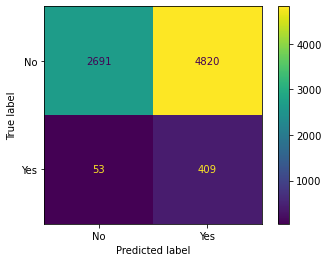

In [94]:
nm_cm = confusion_matrix(y_test, nm_preds)
ConfusionMatrixDisplay(nm_cm, display_labels=['No', 'Yes']).plot();

In [95]:
print(classification_report(y_test, nm_preds))

              precision    recall  f1-score   support

           0       0.98      0.36      0.52      7511
           1       0.08      0.89      0.14       462

    accuracy                           0.39      7973
   macro avg       0.53      0.62      0.33      7973
weighted avg       0.93      0.39      0.50      7973



In [96]:
lr_nm.score(X_train_miss, y_train_miss), lr_nm.score(X_test, y_test)

(0.9179913294797688, 0.3888122413144362)

In [97]:
roc_auc_score(y_test, lr_nm.predict_proba(X_test)[:,1])

0.7417493304192813

#### Decision Tree

In [98]:
tnm = DecisionTreeClassifier(random_state=19)
tnm.fit(X_train_miss, y_train_miss)

DecisionTreeClassifier(random_state=19)

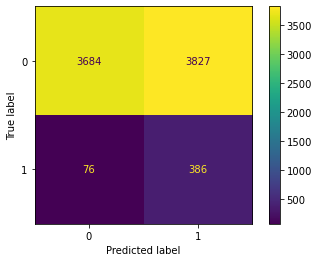

In [99]:
tnm_preds = tnm.predict(X_test)
tnm_cm = confusion_matrix(y_test, tnm_preds)
ConfusionMatrixDisplay(tnm_cm).plot();

In [100]:
print(classification_report(y_test, tnm_preds))

              precision    recall  f1-score   support

           0       0.98      0.49      0.65      7511
           1       0.09      0.84      0.17       462

    accuracy                           0.51      7973
   macro avg       0.54      0.66      0.41      7973
weighted avg       0.93      0.51      0.63      7973



In [101]:
tnm.score(X_train_miss, y_train_miss), tnm.score(X_test, y_test)

(1.0, 0.5104728458547598)

### SelectKBest

In [16]:
kb = SelectKBest(k=10)
X_kb = kb.fit_transform(X_dum, y)

In [28]:
# splitting data into train and test sets for X and y variables
X_train, X_test, y_train, y_test = train_test_split(X_kb, y, stratify=y, random_state=19)

In [29]:
# creating instances to create balanced classes 
sm = SMOTEN(random_state=19)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [30]:
X_train_res.shape, y_train_res.shape

((45068, 10), (45068,))

In [31]:
lrk = LogisticRegression(max_iter=1000)
lrk.fit(X_train_res, y_train_res)

LogisticRegression(max_iter=1000)

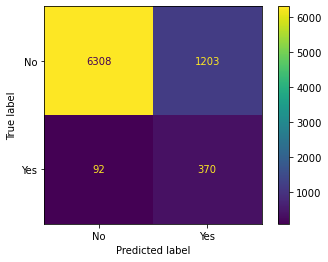

In [32]:
lrk_preds = lrk.predict(X_test)
lrk_cm = confusion_matrix(y_test, lrk_preds)
ConfusionMatrixDisplay(lrk_cm, display_labels=['No', 'Yes']).plot();

In [33]:
print(classification_report(y_test, lrk_preds))

              precision    recall  f1-score   support

           0       0.99      0.84      0.91      7511
           1       0.24      0.80      0.36       462

    accuracy                           0.84      7973
   macro avg       0.61      0.82      0.64      7973
weighted avg       0.94      0.84      0.88      7973



In [34]:
lrk.score(X_train_res, y_train_res), lrk.score(X_test, y_test)

(0.8198500044377385, 0.8375768217734855)

In [35]:
roc_auc_score(y_test, lrk.predict_proba(X_test)[:,1])

0.9112441723279162

In [36]:
coef_df = pd.DataFrame({'coefs': lrk.coef_[0], 'features': kb.get_support(indices=True)})
coef_df['feature_names'] = [X_dum.columns[i] for i in coef_df['features']]
coef_df.sort_values('coefs', ascending=False)

,coefs,features,feature_names
1,1.942693,25,AFNOW_8.0
0,1.796486,23,AFNOW_2.0
2,0.640178,53,OVER65FLG_A_1
9,0.589735,231,EMPWRKLSWK_A_2
8,-0.388614,145,MEDICARE_A_3
7,-0.670145,136,EQUIP_A_2
4,-0.747139,74,CHLEV_A_2
3,-1.017392,71,HYPEV_A_2
5,-2.448198,77,ANGEV_A_2
6,-3.435751,79,MIEV_A_2
